## Przygotowanie

Przed rozpoczęciem pracy z notatnikiem proszę zmienić jego nazwę dodając na początku numer albumu, imię i nazwisko.
{nr_albumu}\_{imię}\_{nazwisko}\_{nazwa}

Po wykonaniu wszystkich zadań proszę przesłać wypełniony notatnik przez platformę ELF za pomocą formularza "Prześlij projekt" w odpowiedniej sekcji. 

## Regresja liniowa wieloraka

Rzadko kiedy zdarza się taka sytuacja, że zależność opisuje się na podstawie tylko jednej zmiennej. Z reguły na wynik zmiennej objaśnianej ($y$) ma wpły więcej różnych cech. Przykładowo, na cenę samochodu ma wpływ rok produkcji, przebieg, ilość koni mechanicznych itp. Dlatego właśnie jest naturalna potrzeba rozwinięcia algorytmu regresji liniowej z jedną cechą na większą ilość cech.

Algorytm, który implementowaliśmy w poprzednim zadaniu jest szczególnym przypadkiem regresji liniowej, ale może zostać on w łatwy sposób uogólniony. Mechanizmy, które poznaliśmy wcześniej takie jak obliczanie funkcji błędu, pochodnych cząstkowych, w dalszym ciągu są aktualne. Trzeba jedynie uwzględnić dodatkowe cechy.

### Zadanie 1

W zbiorze danych z zarobkami, który wykorzystywany był w poprzednim zadaniu, znajduje się pominięta wcześniej cecha. Wczytaj dane z pliku Salary.csv, tym razem z dwiema zmiennymi objaśniającymi: YearsExperience i Age oraz zmienną objaśnianą Salary. Stwórz wykres 3D przedstawiający dane.

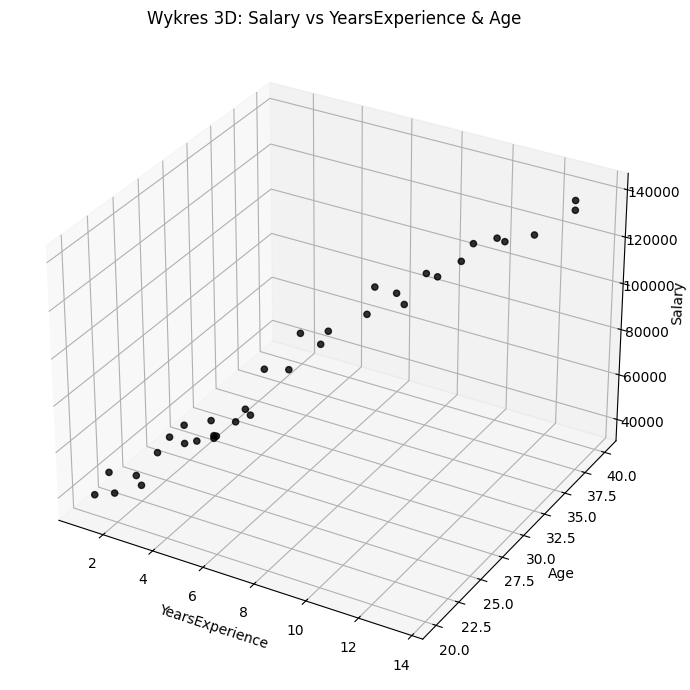

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

df = pd.read_csv('./Salary.csv')

x1 = df['YearsExperience']
x2 = df['Age']
y = df['Salary']

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x1, x2, y, c='black', marker='o', alpha=0.8)

ax.set_xlabel('YearsExperience')
ax.set_ylabel('Age')
ax.set_zlabel('Salary')
ax.set_title('Wykres 3D: Salary vs YearsExperience & Age')

plt.tight_layout()
plt.show()

## Zadanie 2

Przerób algorytm znajdujący się w funkcji _learn_and_fit(x,y)_ w taki sposób, aby uwzględniał dodatkową cechę.
Funkcja regresji liniowej przybierze w tym momencie postać:

\begin{equation}
f(x^{(i)}) = \beta_{0} + \beta_{1}x_1 + \beta_{2}x_2 = \beta_{0} + \beta_{1} YearsExperience + \beta_{2} Age
\end{equation}

Pojawienie się kolejnej cechy wymaga akutalizacji obliczania gradientu. Należy dodatkowo obliczyć pochodną cząstkową względem parametru $\beta_{2}$, a następnie zaktualizować wartość tego parametru. 

Obliczenie pochodnej cząstkowej wygląda analogicznie jak w przypadku parametru $\beta_{1}$.

\begin{equation}
    \frac{\partial SSR}{\partial \beta_{2}} = \frac{1}{n} \sum^{n}_{i=1} (f(x^{(i)}) - y^{(i)})x_{1}^{(i)}
\end{equation}

Aktualizacja wartości współczynnika również jest analogiczna.

\begin{equation}
    \beta_{2} = \beta_{2} - \alpha \frac{\partial SSR}{\partial \beta_{2}} 
\end{equation}

_Uwaga: Zastanów się, w jaki sposób zaimplementować obługę kolejnych cech, tak aby po pojawieniu się 3 cechy nie trzeba było modyfikować algorytmu._

In [3]:
from typing import Tuple, List


def initialize_coefficients(n: int = 2, alpha=None) -> Tuple[np.ndarray, float]:
    # n to liczba cech (nie licząc wyrazu wolnego)
    betas = np.random.rand(n + 1)  # +1 dla beta_0
    if alpha is None:
        alpha = 0.01
    return betas, alpha

def calculate_regression_function(X: np.ndarray, betas: np.ndarray) -> np.ndarray:
    return X.dot(betas)

def calculate_error(X: np.ndarray, y: np.ndarray, betas: np.ndarray) -> float:
    m = len(y)
    predictions = calculate_regression_function(X, betas)
    return (1 / (2 * m)) * np.sum((predictions - y) ** 2)

def calculate_gradient(X: np.ndarray, y: np.ndarray, betas: np.ndarray) -> np.ndarray:
    m = len(y)
    predictions = calculate_regression_function(X, betas)
    gradient = (1 / m) * (X.T.dot(predictions - y))
    return gradient

def update_regression_coefficients(X: np.ndarray, y: np.ndarray, betas: np.ndarray, alpha: float) -> np.ndarray:
    gradient = calculate_gradient(X, y, betas)
    return betas - alpha * gradient



In [17]:
'''
input:
X - wartości zmiennych objaśniających YearsExperience oraz Age dla wszystkich obserwacji
y - wartości zmiennej objaśnianej Salary dla wszystkich obserwacji

output:
b0: [] - lista z współczynnikami beta_0 w każdej z epok
betas: [] - lista z współczynnikami beta_1, beta_2 w każdej z epok
error: [] - lista z błędem w każdej epoce
'''

def learn_and_fit(X: np.ndarray, y: np.ndarray, epochs: int = 1000, alpha: float = None, tolerance: float = 1e-5) -> Tuple[np.ndarray, List[np.ndarray], List[float]]:
    X_augmented = np.c_[np.ones(X.shape[0]), X]  
    betas, alpha = initialize_coefficients(n=X.shape[1], alpha=alpha)

    beta_history = []
    error_history = []

    for epoch in range(epochs):
        error = calculate_error(X_augmented, y, betas)
        if np.isnan(error) or np.isinf(error):
            print(f"STOP: Niestabilność numeryczna w epoce {epoch}, error={error}")
            break
        error_history.append(error)
        beta_history.append(betas.copy())

        if epoch > 0 and abs(error_history[-1] - error_history[-2]) < tolerance:
            print(f"Early stopping w epoce {epoch}")
            break

        betas = update_regression_coefficients(X_augmented, y, betas, alpha)

    b0 = np.array([b[0] for b in beta_history])
    other_betas = np.array([b[1:] for b in beta_history])

    return b0, other_betas, error_history

### Zadanie 3

Do stworzonego z zadaniu 1 wykresu dodaj płaszczyznę regresji. Stwórz 3 wykresy przedstawiające jak zmieniała się funkcja regresji na przestrzeni epok (pierwsza, środkowa, ostatnia epoka).

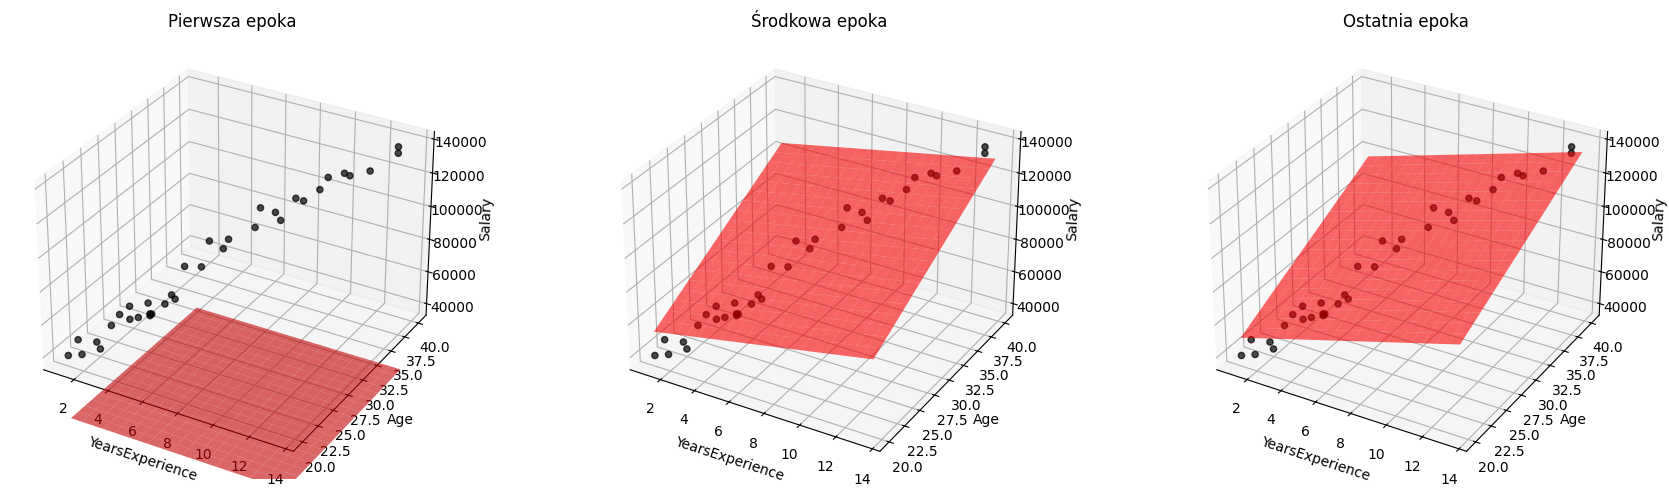

<Figure size 640x480 with 0 Axes>

In [60]:
df = pd.read_csv("./Salary.csv")
X = df[['YearsExperience', 'Age']].values
y = df['Salary'].values

b0, betas, errors = learn_and_fit(X, y, epochs=10000, alpha=1e-5)

epoch_indices = [0, len(b0)//2, len(b0)-1]
epoch_labels = ['Pierwsza epoka', 'Środkowa epoka', 'Ostatnia epoka']

x1_grid, x2_grid = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 20),
    np.linspace(X[:,1].min(), X[:,1].max(), 20)
)

fig = plt.figure(figsize=(18, 5))

for i, idx in enumerate(epoch_indices):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')

    z = b0[idx] + betas[idx][0]*x1_grid + betas[idx][1]*x2_grid

    ax.scatter(X[:, 0], X[:, 1], y, color='black', label='Dane', alpha=0.7)
    ax.plot_surface(x1_grid, x2_grid, z, color='red', alpha=0.6)

    ax.set_title(epoch_labels[i])
    ax.set_xlabel('YearsExperience')
    ax.set_ylabel('Age')
    ax.set_zlabel('Salary')
    ax.set_zlim(y.min() - 5000, y.max() + 5000)  

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


In [43]:
b0[-1],betas[-1],errors[-1]

(np.float64(8.016731657952876),
 array([ 61.41808117, 244.07318223]),
 np.float64(3387692787.67191))

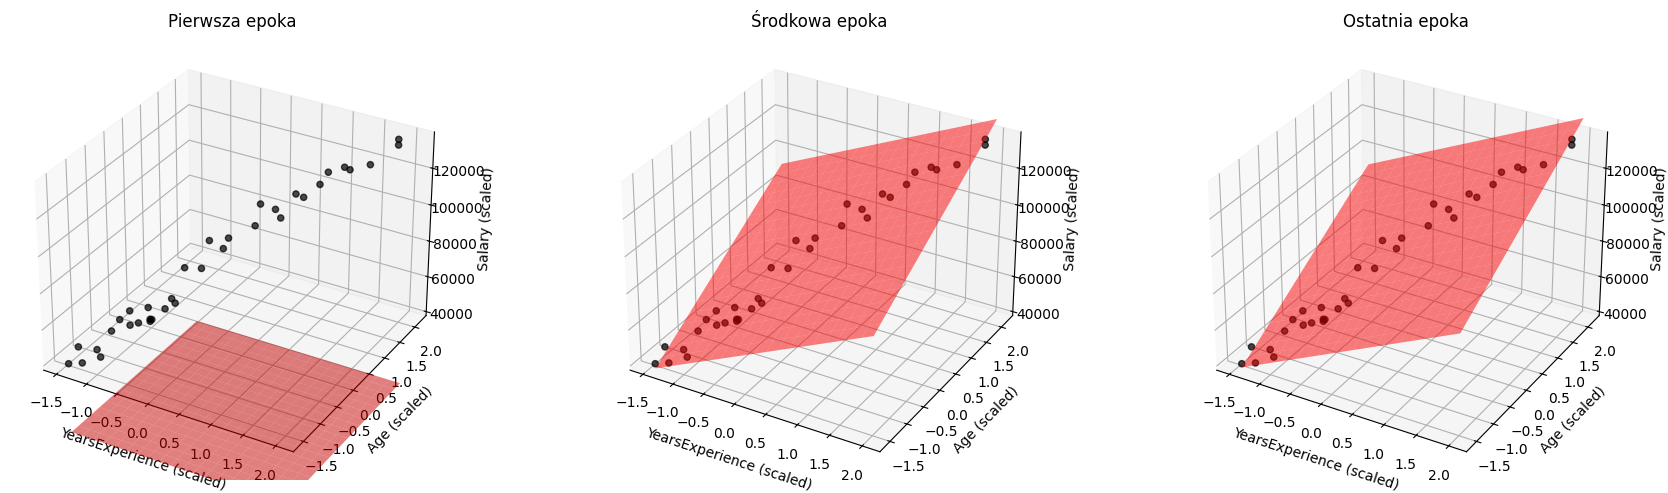

In [61]:
from sklearn.preprocessing import StandardScaler


scaler_X = StandardScaler()

X_scaled = scaler_X.fit_transform(X)

b0, betas, errors = learn_and_fit(X_scaled, y, epochs=1000, alpha=0.01)


x1_grid, x2_grid = np.meshgrid(
    np.linspace(X_scaled[:,0].min(), X_scaled[:,0].max(), 20),
    np.linspace(X_scaled[:,1].min(), X_scaled[:,1].max(), 20)
)

epoch_indices = [0, len(b0)//2, len(b0)-1]
epoch_labels = ['Pierwsza epoka', 'Środkowa epoka', 'Ostatnia epoka']

fig = plt.figure(figsize=(18, 5))

for i, idx in enumerate(epoch_indices):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')

    z = b0[idx] + betas[idx][0]*x1_grid + betas[idx][1]*x2_grid

    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], y, color='black', alpha=0.7, label='Dane')
    ax.plot_surface(x1_grid, x2_grid, z, color='red', alpha=0.5)

    ax.set_title(epoch_labels[i])
    ax.set_xlabel('YearsExperience (scaled)')
    ax.set_ylabel('Age (scaled)')
    ax.set_zlabel('Salary (scaled)')
    ax.set_zlim(y.min() - 1, y.max() + 1)

plt.tight_layout()
plt.show()


In [45]:
b0[-1],betas[-1],errors[-1]

(np.float64(83884.77042185613),
 array([16109.02340748, 15128.43828596]),
 np.float64(17163889.50534504))

### Zadanie 4

W sytuacji, w której zbiór danych zawiera więcej zmiennych objaśniających niż 2, niemożliwym staje się wizualizacja prostej regresji i ocena w taki sposób stworzonego modelu. Bardzo przydatnym rozwiązaniem jest wtedy stworzenie wykresu błędów regresji. Jeśli wartości błędu spadają wraz z kolejnymi epokami, oznacza to, że jesteśmy na dobrej drodze, a nasz algorytm działa poprawnie. Celem tego zadania będzie stworzenie finalnego modelu regresji liniowej, który będzie przyjmował dowolną liczbę zmiennych objaśniających.

Na podstawie wcześniejszych implementacji, stwórz implementację funkcji *learn_and_fit_multi(X, y)*, która będzie przyjmować zbiór wejściowy z dowolną ilością kolum (cech). Dla takiego zbioru zbioru danych ma zostać stworzony model regresji. Funkcja podobnie jak wcześniej, ma zwracać współczynniki oraz wartość błędu w każdej epoce. 

W notebooku z opisem regresji liniowej przedstawione zostały wzory na ogólą postać regresji. Przeanalizuj je jeszcze raz i postaraj się je zaimplementować.

Wczytaj zestaw danych *multi_variable_regression.csv* z katalogu datasets. Dane wygenerowane zostały w taki sposób, że są wysoce liniowo zależne. Wartość błędu dla nauczonego modelu powinna być w takim przypadku niewielka. Przetestuj na wczytanym zbiorze swój algorytm.

In [62]:
def learn_and_fit_multi(X: np.ndarray, y: np.ndarray, epochs: int = 1000, alpha: float = 0.01, tolerance: float = 1e-5) -> Tuple[np.ndarray, List[np.ndarray], List[float]]:
    X_augmented = np.c_[np.ones(X.shape[0]), X]
    betas = np.random.uniform(0, 0.001, size=X_augmented.shape[1])

    beta_history = []
    error_history = []

    for epoch in range(epochs):
        predictions = X_augmented.dot(betas)
        error = (1 / (2 * len(y))) * np.sum((predictions - y) ** 2)

        if np.isnan(error) or np.isinf(error):
            print(f" STOP: Niestabilność numeryczna w epoce {epoch}")
            break

        beta_history.append(betas.copy())
        error_history.append(error)

        if epoch > 0 and abs(error_history[-1] - error_history[-2]) < tolerance:
            print(f" Early stopping w epoce {epoch}")
            break

        gradient = (1 / len(y)) * X_augmented.T.dot(predictions - y)
        betas -= alpha * gradient

    b0 = np.array([b[0] for b in beta_history])
    other_betas = np.array([b[1:] for b in beta_history])
    
    return b0, other_betas, error_history


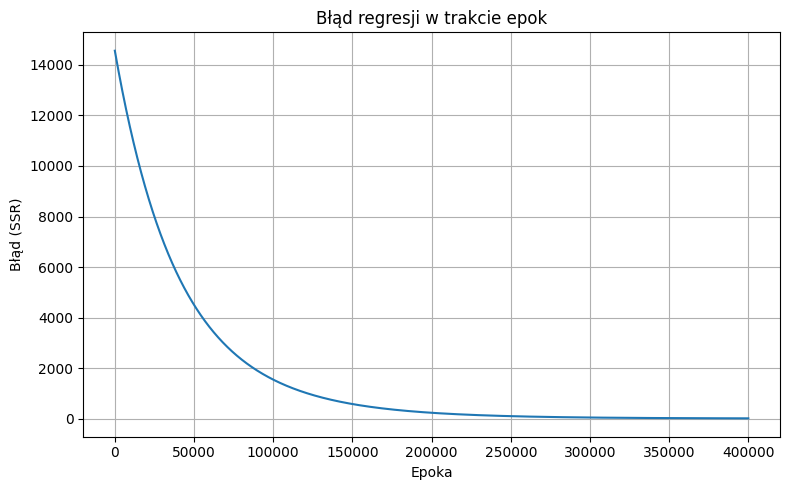

In [67]:
df = pd.read_csv("./multi_variable_regression.csv")

X = df.drop(columns=["y"]).values
y = df["y"].values

b0, betas, errorsM = learn_and_fit_multi(X, y, epochs=400000, alpha=1e-5, tolerance=1e-4)

plt.figure(figsize=(8, 5))
plt.plot(errorsM)
plt.title("Błąd regresji w trakcie epok")
plt.xlabel("Epoka")
plt.ylabel("Błąd (SSR)")
plt.grid(True)
plt.tight_layout()
plt.show()


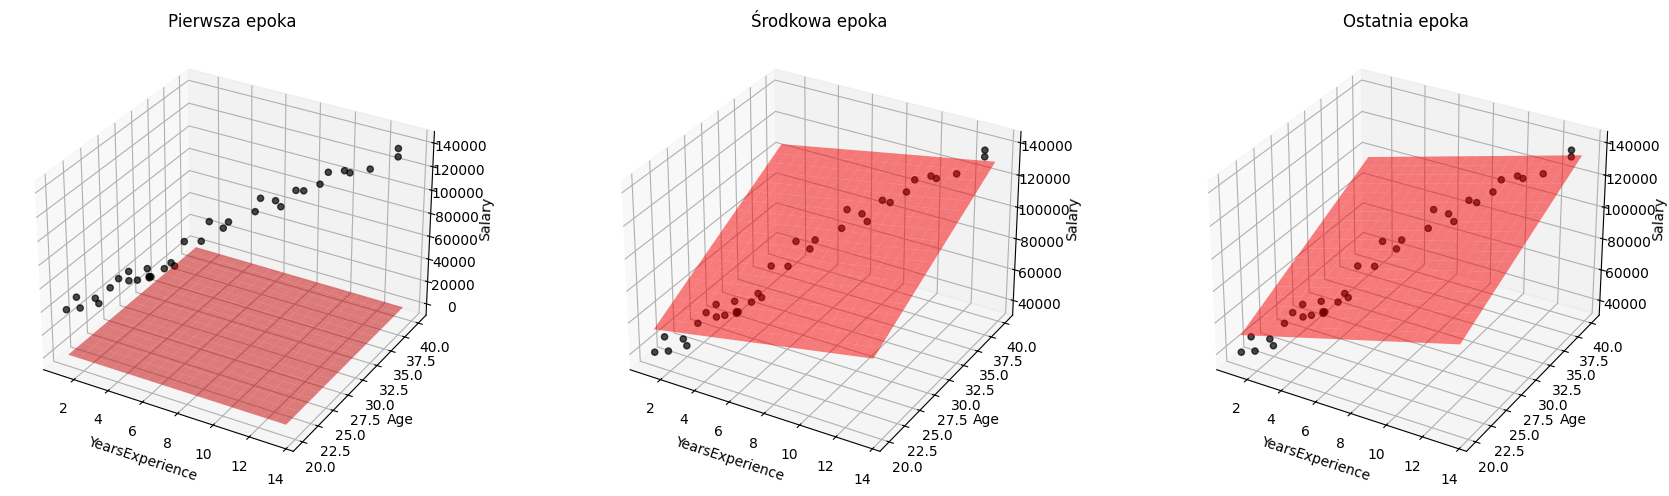

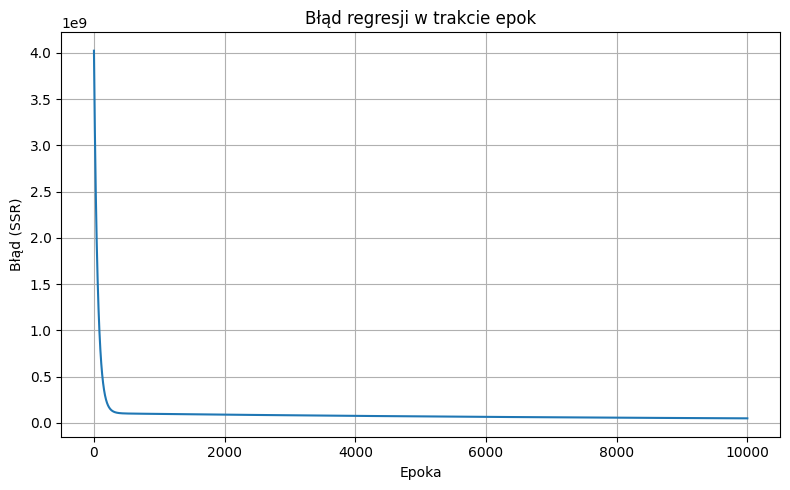

In [64]:

df = pd.read_csv("./Salary.csv")
X = df[['YearsExperience', 'Age']].values
y = df['Salary'].values

b0, betas, errors = learn_and_fit_multi(X, y, epochs=10000, alpha=1e-5, tolerance=1e-4)

epoch_indices = [0, len(b0)//2, len(b0)-1]
epoch_labels = ['Pierwsza epoka', 'Środkowa epoka', 'Ostatnia epoka']

x1_grid, x2_grid = np.meshgrid(
    np.linspace(X[:,0].min(), X[:,0].max(), 20),
    np.linspace(X[:,1].min(), X[:,1].max(), 20)
)

fig = plt.figure(figsize=(18, 5))

for i, idx in enumerate(epoch_indices):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')

    z = b0[idx] + betas[idx][0]*x1_grid + betas[idx][1]*x2_grid

    ax.scatter(X[:, 0], X[:, 1], y, color='black', label='Dane', alpha=0.7)
    ax.plot_surface(x1_grid, x2_grid, z, color='red', alpha=0.5)

    ax.set_title(epoch_labels[i])
    ax.set_xlabel('YearsExperience')
    ax.set_ylabel('Age')
    ax.set_zlabel('Salary')

plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(errors)
plt.title("Błąd regresji w trakcie epok")
plt.xlabel("Epoka")
plt.ylabel("Błąd (SSR)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Zadanie 5

Stwórz wykres przedstawiający zmianę błędu regresji w kolejnych epokach. Napisz co można na jego podstawie wywnioskować.

Na podstawie wykresu można zauważyć, że błąd regresji systematycznie maleje,
co oznacza, że model skutecznie uczy się zależności w danych. 
Wykres wypłaszcza się po kilkuset epokach, co może wskazywać na osiągnięcie minimum funkcji kosztu.


In [66]:
def plot_error_over_epochs(errors: list):
    plt.figure(figsize=(8, 5))
    plt.plot(errors, label='Błąd regresji')
    plt.title("Zmiana błędu regresji w kolejnych epokach")
    plt.xlabel("Epoka")
    plt.ylabel("Błąd (SSR)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Zadanie 6

W jaki sposób współczynnik alpha wpływa na działania algorytmu? Przeprowadź eksperyment dla minimum trzech różnych wartości tego parametru. Sformułuj wnioski. Jak zmiana parametru wpłynęła na ilość epok w algorytmie? Jak zmieniła się funkcja regresji?

In [73]:


df = pd.read_csv("./multi_variable_regression.csv")
X = df.drop(columns=["y"]).values
y = df["y"].values

alphas = [1e-4, 1e-5, 1e-6]
results = {}

for alpha in alphas:
    print(f"\nTrening dla alpha = {alpha}")
    b0, betas, errors = learn_and_fit_multi(X, y, epochs=300000, alpha=alpha, tolerance=1e-4)

    epochs = len(errors)
    final_betas = [b0[-1]] + list(betas[-1])
    
    results[alpha] = {
        "errors": errors,
        "epochs": epochs,
        "betas": final_betas
    }

    print(f"  Liczba epok: {epochs}")
    print(f"  Końcowe współczynniki: {final_betas}")



Trening dla alpha = 0.0001
 Early stopping w epoce 55608
  Liczba epok: 55609
  Końcowe współczynniki: [np.float64(0.05273355552737662), np.float64(49.44489811543898), np.float64(73.8006400778877), np.float64(3.4852803239728267), np.float64(88.57662859555172), np.float64(8.602533016300564), np.float64(97.94452863842363)]

Trening dla alpha = 1e-05
  Liczba epok: 300000
  Końcowe współczynniki: [np.float64(1.5433260072394812), np.float64(48.75560263121481), np.float64(71.84343773522143), np.float64(-0.4909281610194152), np.float64(84.8471743749091), np.float64(7.055440547528969), np.float64(91.98132078480656)]

Trening dla alpha = 1e-06
  Liczba epok: 300000
  Końcowe współczynniki: [np.float64(5.005730029037065), np.float64(17.25565154077563), np.float64(24.813441796295507), np.float64(-6.328594128801445), np.float64(24.66852075063068), np.float64(0.467775163229867), np.float64(24.905275823965923)]


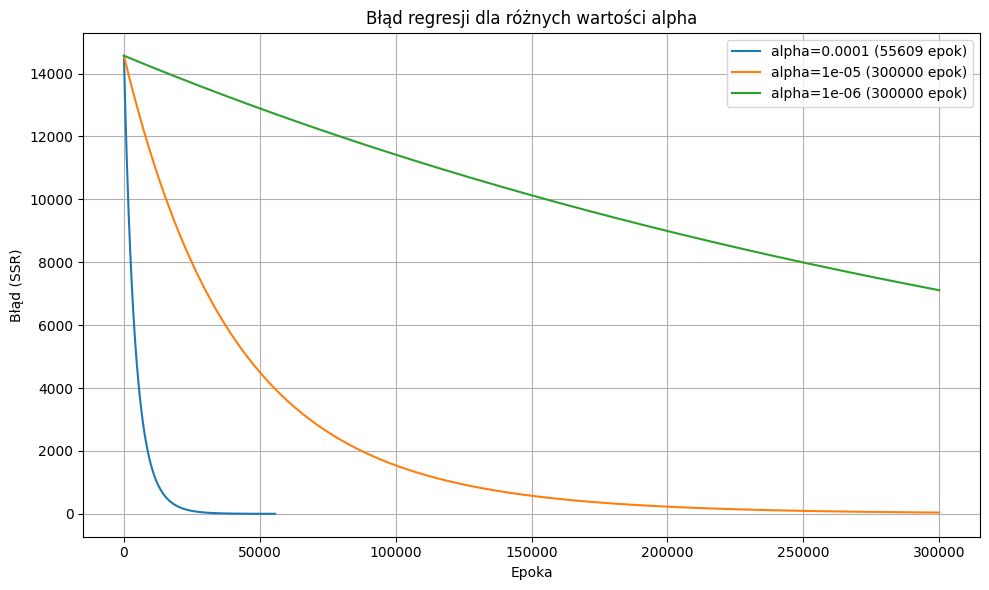

In [74]:
plt.figure(figsize=(10, 6))

for alpha, result in results.items():
    plt.plot(result["errors"], label=f"alpha={alpha} ({result['epochs']} epok)")

plt.title("Błąd regresji dla różnych wartości alpha")
plt.xlabel("Epoka")
plt.ylabel("Błąd (SSR)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


 Wnioski z eksperymentu: 
1. Wpływ alpha na liczbę epok
alpha = 0.0001 → model szybko się uczy, błąd gwałtownie spada i zatrzymuje się po 55 609 epokach dzięki early stopping.
alpha = 1e-5 → wolniejsze uczenie, ale stabilne; model potrzebował maksymalnej liczby epok (300 000) i jeszcze nie osiągnął zera błędu.
alpha = 1e-6 → uczenie bardzo powolne; błąd ledwo się obniża, model nie zdążył się nauczyć w 300 000 epok.

2. Wpływ alpha na jakość dopasowania (funkcję regresji)
Dla większego alpha = 0.0001:
końcowe współczynniki są bliskie docelowym, mają rozsądne wartości,
funkcja regresji dobrze odwzorowuje dane.
Dla alpha = 1e-5:
współczynniki są jeszcze poprawne, ale niektóre zaczynają się "rozjeżdżać" (np. β₃ ≈ -0.49).
Dla alpha = 1e-6:
współczynniki są znacznie mniejsze i niedoszacowane,

funkcja regresji jeszcze się nie nauczyła poprawnych zależności — to znaczy, że potrzeba więcej czasu (lub lepszego alpha).
3. Zachowanie błędu regresji
Wykres pokazuje, że większe alpha powoduje szybszy spadek błędu (ale trzeba uważać na stabilność), mniejsze alpha uczą stabilnie, ale zbyt wolno → mogą nigdy nie osiągnąć sensownego minimum w rozsądnej liczbie epok.

### Zadanie 7

Porównaj czas działania algorytmu we własnej implementacji oraz implementacji z biblioteki Sklearn.

In [ ]:
import time
from sklearn.linear_model import LinearRegression

df = pd.read_csv("./multi_variable_regression.csv")
X = df.drop(columns=["y"]).values
y = df["y"].values

start_custom = time.time()
b0, betas, errors = learn_and_fit_multi(X, y, epochs=5000000, alpha=1e-5, tolerance=1e-4)
end_custom = time.time()
time_custom = end_custom - start_custom

start_sklearn = time.time()
model = LinearRegression()
model.fit(X, y)
end_sklearn = time.time()
time_sklearn = end_sklearn - start_sklearn

print(f"\nCzas działania własnego algorytmu: {time_custom:.4f} sekund")
print(f"Czas działania sklearn: {time_sklearn:.6f} sekund")

print("\nWspółczynniki sklearn:", [model.intercept_, *model.coef_])
print("Współczynniki własnego modelu:", [b0[-1], *betas[-1]])


 Early stopping w epoce 413255

Czas działania własnego algorytmu: 2.0123 sekund
Czas działania sklearn: 0.000423 sekund

Współczynniki sklearn: [np.float64(-3.552713678800501e-15), np.float64(49.489040650922696), np.float64(74.04703360529071), np.float64(4.308597309767962), np.float64(88.8990575124376), np.float64(8.909926619208296), np.float64(98.79788144858396)]
Współczynniki własnego modelu: [np.float64(0.44841121004067963), np.float64(49.31168690060894), np.float64(73.25212524888033), np.float64(2.0703594566615253), np.float64(87.5763443724807), np.float64(8.062950012291676), np.float64(96.11161344205577)]
